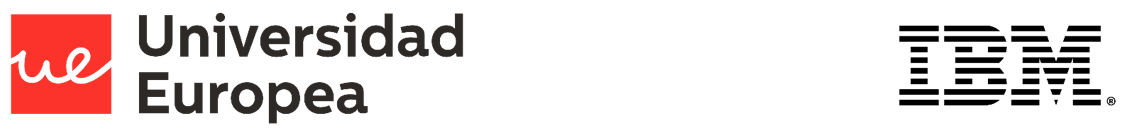
# <font color=#444444> Proyecto Parte I - Ciclo de Vida de los Modelos </font>
### <font color=#999999> Postgrado Onlie IA y Data Science 2020-2021 </font>  
**PROFESOR**: 
**David Kremer García**

Este notebook sirve de guía para el desarrollo del proyecto del módulo de Ciclo de Vida de los Modelos. 

# MNIST 
El set de datos de MNIST (Modified National Institute of Standards and Technology) es muy conocido en problemas de tratamiento y clasificación de imágenes con Machine Learning y Deep Learning y sirve como problema de prueba con el que se desarrollan y miden la mayoría de los algoritmos de clasificación de imágenes.

Consite en un set de imágenes con dígitos escritos a mano. Cada imagen, en blanco y negro y de 28x28 píxeles, contiene un dígito del 0 al 9, y está anotada (está identificado el dígito que contiene). 

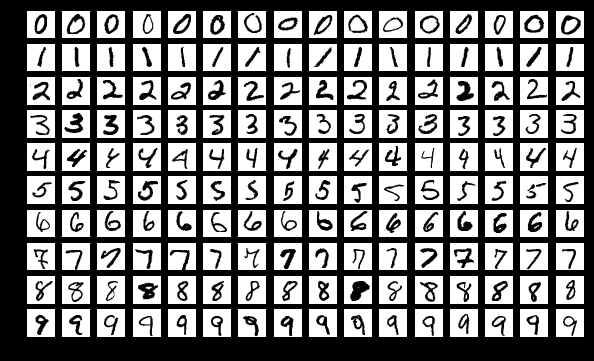

El problema consiste en identificar, dada una imagen, a cual de los dígitos corresponde (es un problema de clasificación). El set de datos contiene 70.000 imágenes de dígitos escritos a mano, separadas en 60.000 de training y 10.000 de testing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
import torch
from skimage.feature import hog

In [2]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

In [3]:
import random
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0)

# 1. Carga, visualización/exploración y reescalado de las imágenes (2 puntos)

Las imágenes están almacenadas en formato pickle. Antes de desarrollar el modelo, al igual que hemos hecho en ejercicios anteriores, hay que cargar los datos y conviene hacer una exploración y visualización de las imágenes.

Este apartado consiste en:
 - Cargar las imágenes desde el pickle y comprobar el número de filas y resolución del dataset
 - Visualizar una serie de imágenes
 - Reescalar las imágenes para que los valores de los datos estén entre -0.5 y 0.5

Importamos la libreria pickle y los sets de train y test

In [4]:
import pickle
with open('data/MNIST_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)
with open('data/MNIST_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)

Vemos que los sets estan compuestos por imagenes de 28x28 pixeles y que tenemos 60.000 imagenes para el set de train y 10.000 para el set de test.

In [5]:
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [6]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


Pintamos algunas imagenes a ver que aspecto tienen y sacamos el valor esperado.

Vemos imagenes de los siguiente numeros [4 1 7 1 8 7]


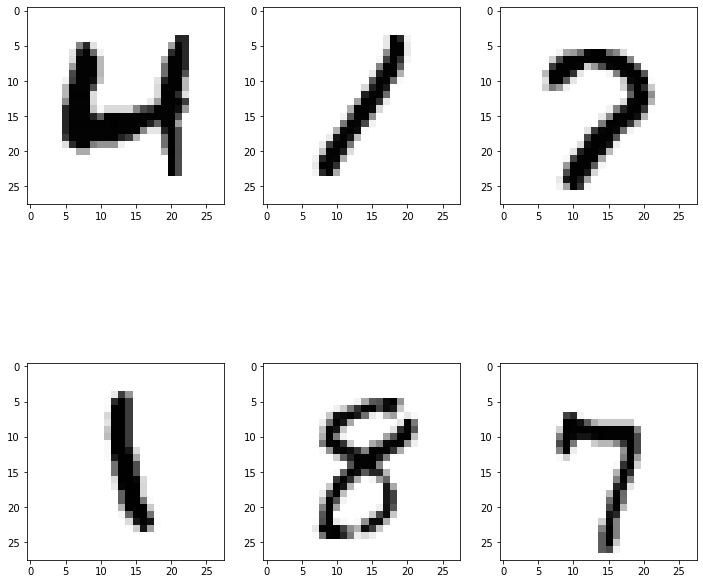

In [7]:
n_imag = 6 
list_imag = np.random.randint(0, high=X_train.shape[0], size=n_imag)
io.imshow_collection(np.array([ 255-X_train[i,:,:] for i in list_imag ]), cmap=plt.cm.gray)
print('Vemos imagenes de los siguiente numeros',y_train[list_imag])

Normalizamos los valores para que esten entre -0.5 y 0.5. Para muchos modelos de Machine Learning esto es importante. 

In [8]:
X_train_n = (0.5 - X_train / 255)
X_test_n = (0.5 - X_test / 255)

In [9]:
X_train_n.max(), X_train_n.min()

(0.5, -0.5)

# 2. Entrenamiento de modelos de ML tradicionales con HOG features (2 puntos)

Para conseguir modelos mas robustos, podemos hacer uso de HOG features para procesar las imágenes de forma que obtengamos unas variables de entrada mas genéricas que los valores específicos de los píxeles.

Esta parte consiste en, al igual que hicimos en ejercicios anteriores:
 - Extraer las HOG features de las imágenes para obtener un dataset transformado con el que entrenar
 - Elegir 3 algoritmos de ML clásico (de scikit-learn) y entrenar modelos de clasificación con el dataset transformado 

Extraemos los HOG features de cada una de las imagenes.
- Usamos diferentes tamaños de celda y concatenamos los resultados de los diferentes tamaños (14, 7 y 4).
- Los gradientes los extraemos en 8 direcciones. 
- Cada imagen correspondera a un elemento de la lista

In [10]:
from skimage.feature import hog

In [11]:
X_train_hog = np.concatenate([np.concatenate([hog(xi, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_train_n[:,:,:]],
                                              axis=0) for ppc in [14,7,4]], axis=1)

X_test_hog = np.concatenate([np.concatenate([hog(xi, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test_n[:,:,:]],
                                              axis=0) for ppc in [14,7,4]], axis=1)

In [12]:
print(X_train_hog.shape)
print(X_test_hog.shape)

(60000, 552)
(10000, 552)


Probamos 3 algoritmos clasicos:
- Una regression logistica
- Un KNeighbors
- Un Extra Tree Classifier 

#### Regresion Logistica

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='newton-cg' )
clf.fit(X_train_hog, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [14]:
print('Porcentaje acierto en train = %5.2f' % (clf.score(X_train_hog, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (clf.score(X_test_hog, y_test)*100),'%')

Porcentaje acierto en train = 98.75 %
Porcentaje acierto en test = 97.96 %


#### KNeighborns

In [15]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_hog, y_train)

KNeighborsClassifier()

In [16]:
print('Porcentaje acierto en train = %5.2f' % (neigh.score(X_train_hog, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (neigh.score(X_test_hog, y_test)*100),'%')

Porcentaje acierto en train = 97.14 %
Porcentaje acierto en test = 95.49 %


#### Extra Tree Classifier

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

cet = ExtraTreesClassifier(n_estimators=100, random_state=0)
cet.fit(X_train_hog, y_train)

ExtraTreesClassifier(random_state=0)

In [18]:
print('Porcentaje acierto en train = %5.2f' % (cet.score(X_train_hog, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (cet.score(X_test_hog, y_test)*100),'%')

Porcentaje acierto en train = 100.00 %
Porcentaje acierto en test = 97.65 %


El mejor resultado parece estar siendo con Extra Tree Classifier, aunque la regresion no se queda lejos. Vamos a pintar algunos de los casos para los que el algoritmo esta fallando. 

In [19]:
fallos = (cet.predict(X_test_hog) != y_test)
X_test_f = X_test[fallos]
y_test_f = y_test[fallos]

Valores estimados: [0, 3, 3, 5, 5, 4]
Valores reales:    [9, 5, 9, 8, 3, 9]


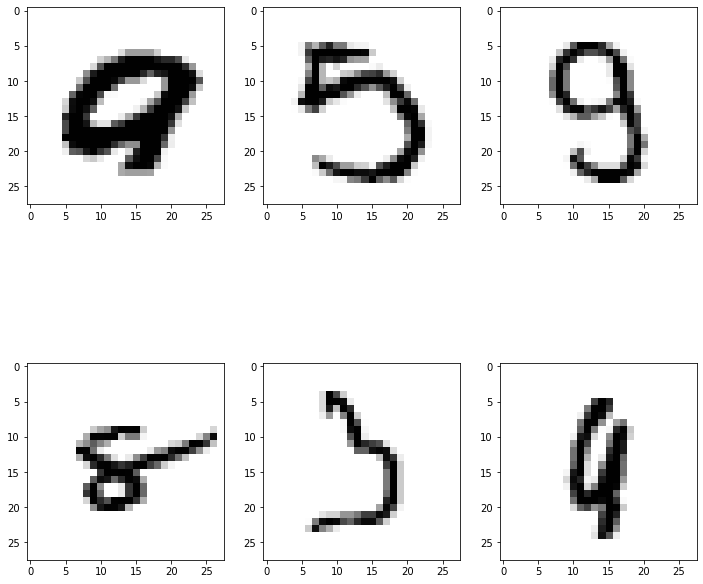

In [20]:
n_imag = 6 
list_imag = np.random.randint(0, fallos.sum(), size=n_imag)
io.imshow_collection(np.array([0.5-X_test_f[i,::] for i in list_imag ]), cmap=plt.cm.gray)
print('Valores estimados:',[cet.predict(X_test_hog[fallos])[i] for i in list_imag])
print('Valores reales:   ',[y_test_f[i] for i in list_imag])

En general vemos que podemos distinguir los fallos y seríamos capaces de clasificarlos bien. 

# 3.	Grid search de hiperparámetros de los modelos y HOG features (1 punto)

Para refinar los modelos entrenados en el apartado anterior, en este apartado el objetivo es:
- Desarrollar una pipeline de scikit-learn con las transformaciones realizadas (incluyendo HOG features) y los modelos desarrollados
- Hacer un grid search sobre esta pipeline para hacer una selección de los hiperparámetros los modelos y de los hiperparámetros de la transformación HOG

El grid search es una operación bastante costosa computacionalmente. Por ello vamos a hacer una primera busqueda con los parametros más relevantes para los distintos algoritmos con un set limitado. Para ello tomaremos solo 1 de cada 100 elementos por lo que reducimos el set de 60000 a 600. Esta reducción es muy drástica pero lo hacemos así a modo ilustrativo por tratarse de una práctica con fines academicos y no un caso real. En un caso real tendríamos que valorar el tiempo y capacidad de calculo de las que se dispone para valorar las distintas posibilidades.

In [21]:
### Transform HOG
from sklearn.base import TransformerMixin

class Hog_param(TransformerMixin): 
    def __init__(self, pcc_list=[4], orien=4) -> pd.DataFrame:
        self.pcc_list = pcc_list
        self.orien = orien
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.concatenate([np.concatenate([hog(xi, orientations=self.orien, 
                                            pixels_per_cell=(ppc, ppc),
                                            cells_per_block=(1, 1), 
                                            visualize=False,
                                            block_norm='L1')[np.newaxis, :] for xi in X[:,:,:]],
                                            axis=0) for ppc in self.pcc_list], axis=1)        
              
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self                
            

Otro hiperparametro a optimizar en nuestro modelo podría ser el block norm de la transformacion HOG. Sin perdida de generalidad y por ahorro de tiempo máquina vamos a omitir esta opción.

In [22]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Optimizacion de la Regresion Logistica

In [24]:
trans_hog = ('trans_hog', Hog_param())
clf_LR = ('clf_LR', LogisticRegression(random_state=0, solver='newton-cg'))

lr_pipeline = Pipeline([trans_hog,clf_LR])
            
alphas = np.logspace(-2., 0, 4)
lr_params_pipe = {'trans_hog__pcc_list': [[28],[14],[7],[4],[14,4], [14,7], [14,7,4], [28,14,7,4,2]],
                  'trans_hog__orien': [4,6,8],
                  'clf_LR__C': alphas }


In [25]:
clf_LR_gs = GridSearchCV(estimator=lr_pipeline,
                         param_grid=lr_params_pipe,
                         cv=skf,
                         scoring='f1_weighted' ) 

In [26]:
clf_LR_gs.fit(X_train_n[::100,:,:], y_train[::100]) 
df_cv_results = pd.DataFrame(clf_LR_gs.cv_results_)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_LR__C,param_trans_hog__orien,param_trans_hog__pcc_list,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,1.400655,0.047632,0.331307,0.010485,1.0,6,"[28, 14, 7, 4, 2]","{'clf_LR__C': 1.0, 'trans_hog__orien': 6, 'tra...",0.966619,0.909342,0.933338,0.933016,0.916470,0.931757,0.019777,1
63,1.412422,0.046683,0.333707,0.013785,0.215443,6,"[28, 14, 7, 4, 2]","{'clf_LR__C': 0.21544346900318834, 'trans_hog_...",0.958313,0.908790,0.925171,0.941311,0.916470,0.930011,0.017809,2
71,1.481639,0.045567,0.334705,0.014126,0.215443,8,"[28, 14, 7, 4, 2]","{'clf_LR__C': 0.21544346900318834, 'trans_hog_...",0.958479,0.925895,0.892524,0.923788,0.924471,0.925031,0.020872,3
95,1.483337,0.045722,0.351058,0.013627,1.0,8,"[28, 14, 7, 4, 2]","{'clf_LR__C': 1.0, 'trans_hog__orien': 8, 'tra...",0.958230,0.925895,0.883794,0.924070,0.924471,0.923292,0.023620,4
79,1.376917,0.049113,0.323933,0.009595,1.0,4,"[28, 14, 7, 4, 2]","{'clf_LR__C': 1.0, 'trans_hog__orien': 4, 'tra...",0.933673,0.891101,0.932959,0.924642,0.932998,0.923075,0.016329,5


### Optimizacion del K_Neibourgh

In [27]:
trans_hog = ('trans_hog', Hog_param())
clf_KN = ('clf_KN', KNeighborsClassifier(n_jobs=-1))

kn_pipeline = Pipeline([trans_hog,clf_KN])
            
kn_params_pipe = {'trans_hog__pcc_list': [[14,4], [14,7], [14,7,4], [28,14,7,4,2]],
                  'trans_hog__orien': [4,6,8],
                  'clf_KN__n_neighbors': [2, 3, 4, 5, 6], 
                  'clf_KN__weights': ['uniform', 'distance']}


In [28]:
clf_KN_gs = GridSearchCV(estimator=kn_pipeline,
                         param_grid=kn_params_pipe,
                         cv=skf,
                         scoring='f1_weighted' ) 

In [29]:
clf_KN_gs.fit(X_train_n[::100,:,:], y_train[::100]) 
df_cv_results = pd.DataFrame(clf_KN_gs.cv_results_)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_KN__n_neighbors,param_clf_KN__weights,param_trans_hog__orien,param_trans_hog__pcc_list,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
63,1.351385,0.044553,0.332909,0.015131,4,distance,4,"[28, 14, 7, 4, 2]","{'clf_KN__n_neighbors': 4, 'clf_KN__weights': ...",0.876279,0.844339,0.882418,0.853648,0.882663,0.867869,0.015857,1
114,0.497669,0.012725,0.119581,0.004619,6,distance,6,"[14, 7, 4]","{'clf_KN__n_neighbors': 6, 'clf_KN__weights': ...",0.891936,0.854063,0.866862,0.857472,0.868900,0.867847,0.013266,2
38,0.494477,0.005760,0.119680,0.002092,3,distance,4,"[14, 7, 4]","{'clf_KN__n_neighbors': 3, 'clf_KN__weights': ...",0.883201,0.842705,0.901253,0.835589,0.874658,0.867481,0.024780,3
26,0.511631,0.014048,0.125664,0.005535,3,uniform,4,"[14, 7, 4]","{'clf_KN__n_neighbors': 3, 'clf_KN__weights': ...",0.874170,0.842844,0.900098,0.844240,0.875733,0.867417,0.021558,4
102,0.487097,0.009516,0.119081,0.006693,6,uniform,6,"[14, 7, 4]","{'clf_KN__n_neighbors': 6, 'clf_KN__weights': ...",0.884083,0.853446,0.875054,0.858065,0.859593,0.866048,0.011581,5


### Optimizacion del Extra Trees

In [30]:
trans_hog = ('trans_hog', Hog_param())
clf_ETC = ('clf_ETC', ExtraTreesClassifier(random_state=0, n_jobs=-1))

etc_pipeline = Pipeline([trans_hog,clf_ETC])
            
etc_params_pipe = {'trans_hog__pcc_list': [[14,4], [14,7], [14,7,4], [28,14,7,4,2]],
                   'trans_hog__orien': [4,6,8],
                   'clf_ETC__n_estimators': [80,90,100,120],
                   'clf_ETC__min_samples_split': [2,4,10],
                   'clf_ETC__criterion': ['gini', 'entropy' ] }


In [31]:
clf_ETC_gs = GridSearchCV(estimator=etc_pipeline,
                         param_grid=etc_params_pipe,
                         cv=skf,
                         scoring='f1_weighted' ) 

In [32]:
clf_ETC_gs.fit(X_train_n[::100,:,:], y_train[::100]) 
df_cv_results = pd.DataFrame(clf_ETC_gs.cv_results_)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_ETC__criterion,param_clf_ETC__min_samples_split,param_clf_ETC__n_estimators,param_trans_hog__orien,param_trans_hog__pcc_list,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,0.566882,0.020733,0.124070,0.004445,gini,2,100,6,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.949998,0.941158,0.925494,0.941742,0.916895,0.935058,0.012054,1
18,0.527390,0.014081,0.121674,0.002276,gini,2,90,6,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.941442,0.942063,0.925494,0.933445,0.916895,0.931868,0.009622,2
6,0.523399,0.009781,0.121276,0.001493,gini,2,80,6,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.932622,0.950017,0.925494,0.916269,0.925652,0.930011,0.011272,3
42,0.541152,0.020639,0.126861,0.002309,gini,2,120,6,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.942146,0.950017,0.925494,0.908725,0.915787,0.928434,0.015562,4
90,0.547335,0.017655,0.128456,0.007554,gini,4,120,6,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.941397,0.941672,0.916641,0.909284,0.924734,0.926745,0.013027,5


### Seleccion de modelo e hiperparametros

Una vez hecho un grid search sobre los distintos modelos seleccionamos el más prometedor y afinamos la busqueda de hiperparametros a un espacio de busqueda más reducido. En este caso solo estamos evaluando 4 casos sin perdida de generalidad en el concepto académico y reduciendo el tiempo de calculo considerablemente. 

Hemos seleccionado el Extra Trees como el algoritmo más prometedor y evaluamos los parametros que usamos inicialmente y que en el estudio sobre un espacio limitado del training van un poco en contra de nuestra intuición. Así, nosotros esperaríamos que el algoritmo funcionase mejor con más parametros HOG pero nos esta reportando que no es así y selecciona solo 6 direcciones y en tamaños de celda 14, 7 y 4 en lugar de 8 direcciones en todos los tamaños posibles. 

In [33]:
trans_hog = ('trans_hog', Hog_param())
clf_ETC = ('clf_ETC', ExtraTreesClassifier(random_state=0, n_jobs=-1))

etc_pipeline = Pipeline([trans_hog,clf_ETC])
            
etc_params_pipe_2 = {'trans_hog__pcc_list': [ [14,7,4], [28,14,7,4]],
                   'trans_hog__orien': [6,8],
                   'clf_ETC__n_estimators': [100],
                   'clf_ETC__min_samples_split': [2],
                   'clf_ETC__criterion': ['gini'] }

In [34]:
clf_ETC_gs = GridSearchCV(estimator=etc_pipeline,
                         param_grid=etc_params_pipe_2,
                         cv=skf,
                         scoring='f1_weighted' ) 

In [35]:
clf_ETC_gs.fit(X_train_n, y_train) 
df_cv_results = pd.DataFrame(clf_ETC_gs.cv_results_)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_ETC__criterion,param_clf_ETC__min_samples_split,param_clf_ETC__n_estimators,param_trans_hog__orien,param_trans_hog__pcc_list,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,58.445322,1.367888,12.950246,0.276098,gini,2,100,6,"[28, 14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.975058,0.979747,0.976834,0.977577,0.979408,0.977725,0.001723,1
0,53.888201,0.703891,11.591440,0.055532,gini,2,100,6,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.975320,0.980243,0.976672,0.976239,0.976990,0.977093,0.001672,2
2,56.722074,0.754380,11.970886,0.212181,gini,2,100,8,"[14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.974980,0.977072,0.975585,0.977158,0.976405,0.976240,0.000846,3
3,62.963410,1.945067,13.268525,0.260230,gini,2,100,8,"[28, 14, 7, 4]","{'clf_ETC__criterion': 'gini', 'clf_ETC__min_s...",0.973743,0.977162,0.975917,0.975916,0.976902,0.975928,0.001204,4


Vemos que los valores son practicamente iguales, aunque según el estudio vamos a seleccionar solo 6 direcciones en lugar de 8 para el HOG y haremos la transformación para 28, 14, 7 y 4 pixeles. 

### Entrenamiento de los modelos optimizados

Este paso es necesario ya que no tenemos los modelos entrenados con el set completo. En la selección dejamos los parametros de HOG iguales para los tres modelos que son los seleccionados del estudio sobre el set completo con el Extra Tree. Podrían tener distintos optimos pero intuitivamente si los modelos estan bien normalizados todos deberían tener el mismo. Además estos son los unicos resultados sobre el set completo. 

In [36]:
hog_opt = Hog_param(orien=6,pcc_list=[28,14,7,4] )

X_train_hog = hog_opt.transform(X_train_n)
X_test_hog = hog_opt.transform(X_test_n)

#### Regresion Logistica

In [37]:
clf = LogisticRegression(random_state=0, solver='newton-cg', C=1 )
clf.fit(X_train_hog, y_train)

LogisticRegression(C=1, random_state=0, solver='newton-cg')

In [38]:
print('Porcentaje acierto en train = %5.2f' % (clf.score(X_train_hog, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (clf.score(X_test_hog, y_test)*100),'%')

Porcentaje acierto en train = 98.57 %
Porcentaje acierto en test = 97.84 %


#### KNeighborns

In [39]:
neigh = KNeighborsClassifier(n_neighbors=4,weights='distance')
neigh.fit(X_train_hog, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [40]:
print('Porcentaje acierto en train = %5.2f' % (neigh.score(X_train_hog, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (neigh.score(X_test_hog, y_test)*100),'%')

Porcentaje acierto en train = 100.00 %
Porcentaje acierto en test = 95.97 %


#### Extra Tree Classifier

In [41]:
cet = ExtraTreesClassifier(n_estimators=100, random_state=0, min_samples_split=2, criterion='gini' )
cet.fit(X_train_hog, y_train)

ExtraTreesClassifier(random_state=0)

In [42]:
print('Porcentaje acierto en train = %5.2f' % (cet.score(X_train_hog, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (cet.score(X_test_hog, y_test)*100),'%')

Porcentaje acierto en train = 100.00 %
Porcentaje acierto en test = 97.90 %


# 4. Diseño de red neuronal “fully connected”, no convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, los modelos de Deep Learning son capaces de "capturar" features a partir de los datos. 

El objetivo de esta sección es:
- Construir una red neuronal no convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

Empezamos por definir el devide donde se van a realizar los calculos, algo util cuando se trabaja con PyTorch. 

In [43]:
dev = torch.device('cuda:0' if  torch.cuda.is_available() else 'cpu')
dev

device(type='cuda', index=0)

#### Deficion de la red

Definimos una red neuronal fully conected con una capa interna de 20 nodos y la cargamos en el hardware correspondiente para poder operar con ella.


In [44]:
nn_fc = torch.nn.Sequential(
    torch.nn.Linear(28*28,50),
    torch.nn.ReLU(),
    torch.nn.Linear(50,10),
    torch.nn.LogSoftmax(dim=1)
)

In [45]:
type(dev)
if dev.type == 'cuda' :
    nn_fc.cuda()

Definimos las imagenes en forma de tensor y cargamos estos tensores en el mismo hardware donde tenemos la red.

In [46]:
tX_train = torch.tensor(X_train_n, requires_grad=False, dtype=torch.float, device=dev)
tX_test = torch.tensor(X_test_n, requires_grad=False, dtype=torch.float, device=dev)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long, device=dev)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long, device=dev)  

Para que la red fully conected funcione tenemos que pasar cada pixel a un nodo de entrada y para ello aplanamos la imagen en forma de vector. Definimos la funcion para "aplanar".

In [47]:
def aplana(tensor): 
    return tensor.view(tensor.shape[0], 28*28)

In [48]:
print(tX_train.shape)
print(aplana(tX_train).shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 784])


Hacemos un forward pass y tambien revisamos cuantos parametros entrenables tendrá la red. 

In [49]:
nn_fc(aplana(tX_train)).shape

torch.Size([60000, 10])

In [50]:
print('Numero de parametros entrenables en el modelo =',np.sum([np.prod(p.shape) for p in nn_fc.parameters()]))

Numero de parametros entrenables en el modelo = 39760


# 5. Entrenamiento red neuronal “fully connected”. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

#### Contruccion de funciones auxiliares.

Empezamos por definir una función para inicializar la red usando el algoritmo normal Xavier

In [51]:
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

In [52]:
for name, param in nn_fc.named_parameters():
    print(name, param.shape) 

0.weight torch.Size([50, 784])
0.bias torch.Size([50])
2.weight torch.Size([10, 50])
2.bias torch.Size([10])


Definir la funcion de loss como el NLLLoss (negative log likelihood loos). Que se basa en penalizar las probabilidades altas en las predicciones erroneas.

In [53]:
def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y)

In [54]:
loss_f(aplana(tX_train), ty_train, nn_fc) # Vemos que nos devuelve un tensor con su gradiente

tensor(2.3051, device='cuda:0', grad_fn=<NllLossBackward>)

Definimos además la funcion para predecir que se queda con la predicción más alta y la función de score que nos da una media del acierto en las predicciones.

In [55]:
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

In [56]:
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

In [57]:
print('Porcentaje acierto en train = %5.2f' % (score_f(aplana(tX_train), ty_train, nn_fc)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (score_f(aplana(tX_test), ty_test, nn_fc)*100),'%')

Porcentaje acierto en train = 11.37 %
Porcentaje acierto en test = 11.25 %


Vemos que al no estar la red entrenada nuestro porcentaje de acierto es bastante bajo. 

#### Definicion de la funcion step (paso de entrenamiento)

Definimos una función que de un paso de entrenamiento usando las funciones de anteriores.

In [58]:
def t_step(x, y, forw, opt):
    opt.zero_grad() # reseteamos los valores acumulados de las derivadas
    loss = loss_f(x, y, forw) # calculamos la 'loss' con los resultados 
    out = loss.item() # almacenamos nuestro valor de loss para devolverlo como resultado intermedio
    loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
    opt.step() # ejecutamos un paso de nuestro optimizador
    return out

#### Entrenamiento

Para el optimizador hemos visto durante la practica que Adam funcionaba mejor por lo que usamos ese.

In [59]:
opt1 = torch.optim.Adam(nn_fc.parameters(), weight_decay=0.008, lr=0.0002)

Inicializamos los pesos de la red con la funcion que definimos.

In [60]:
do_seeds(28)
init_f(nn_fc)

Sin perdida de generalidad entrenaremos esta red (fully connected) usando un fully gradient descent mientras que para la red convolucional usaremos una estrategia de mini-baches. Durante la práctica hemos estado trabajando con las dos y parece que cada una funcina mejor con la seleccionada. Además en la red convolucional a veces teníamos problemas de memoria en la grafica al entrenar. 

En un entrenamiento puro no necesitarímaos evaluar las perdidas sobre el set de test lo que haría el entrenamiento más rápido, aun así mejora el entendimiento del problema por lo que lo hacemos así. 

In [61]:
tr_stats = list()
for i in range(20000):
    temp_stats = ([i,t_step(aplana(tX_train), ty_train, nn_fc, opt1), loss_f(aplana(tX_test), ty_test, nn_fc).item() , 
              score_f(aplana(tX_train), ty_train, nn_fc), score_f(aplana(tX_test), ty_test, nn_fc) ])
    tr_stats.append(temp_stats)
    if i%1000 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, temp_stats[1]))
print("Epoch: {}, Loss: {:.4f}".format(i, temp_stats[1]))     

Epoch: 0, Loss: 2.4137
Epoch: 1000, Loss: 0.3134
Epoch: 2000, Loss: 0.2673
Epoch: 3000, Loss: 0.2480
Epoch: 4000, Loss: 0.2383
Epoch: 5000, Loss: 0.2331
Epoch: 6000, Loss: 0.2300
Epoch: 7000, Loss: 0.2280
Epoch: 8000, Loss: 0.2270
Epoch: 9000, Loss: 0.2263
Epoch: 10000, Loss: 0.2258
Epoch: 11000, Loss: 0.2253
Epoch: 12000, Loss: 0.2249
Epoch: 13000, Loss: 0.2243
Epoch: 14000, Loss: 0.2240
Epoch: 15000, Loss: 0.2238
Epoch: 16000, Loss: 0.2237
Epoch: 17000, Loss: 0.2237
Epoch: 18000, Loss: 0.2236
Epoch: 19000, Loss: 0.2236
Epoch: 19999, Loss: 0.2236


In [62]:
tr_stats_df = pd.DataFrame(tr_stats, columns=['epoch', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])

[None]

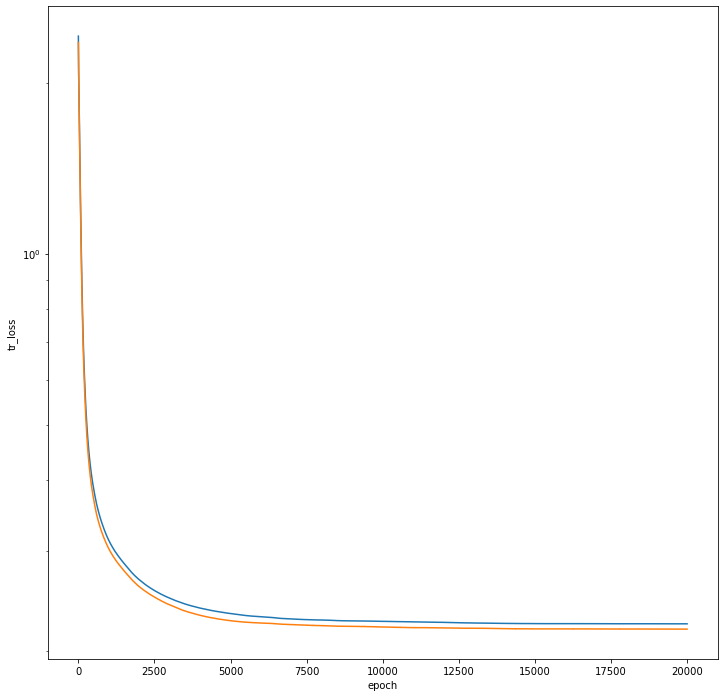

In [63]:
ax = sns.lineplot(x='epoch', y='tr_loss', data=tr_stats_df, legend='full')
sns.lineplot(x='epoch', y='te_loss', data=tr_stats_df, legend='full', ax=ax)
ax.set(yscale="log")

<AxesSubplot:xlabel='epoch', ylabel='tr_score'>

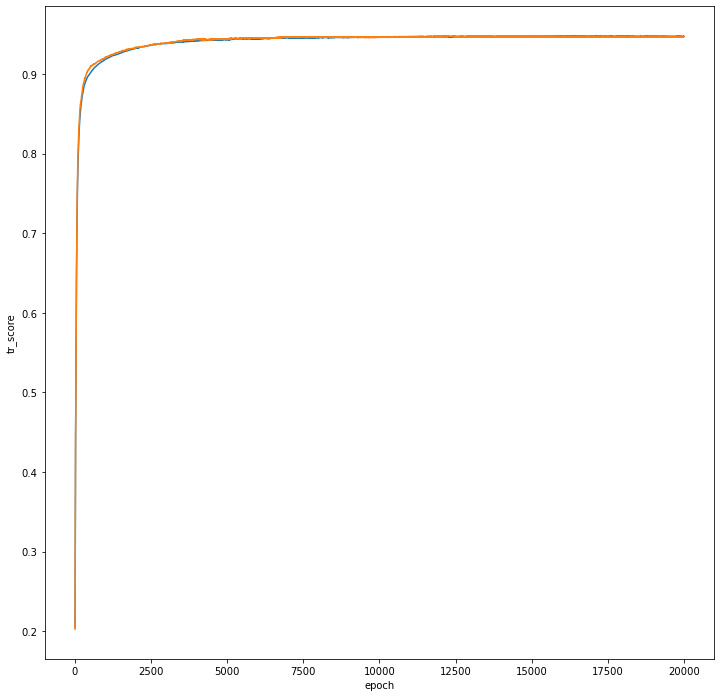

In [64]:
sns.lineplot(x='epoch', y='tr_score', data=tr_stats_df)
sns.lineplot(x='epoch', y='te_score', data=tr_stats_df)

In [65]:
print('Porcentaje acierto en train = %5.2f' % (score_f(aplana(tX_train), ty_train, nn_fc)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (score_f(aplana(tX_test), ty_test, nn_fc)*100),'%')

Porcentaje acierto en train = 94.73 %
Porcentaje acierto en test = 94.72 %


In [66]:
torch.save(nn_fc.state_dict(), 'nn_fc.pt')

# 6. Diseño de red neuronal convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, las redes convolucionales presentan mejores resultados para la clasificación de imágenes, ya que capturan mejor la estructura y correlación entre píxeles cercanos. 

El objetivo de esta sección es:
- Construir una red neuronal convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [67]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [68]:
nn_cv = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), #ch_in, ch_out, size # salida 24x28x28
    torch.nn.LeakyReLU(),    
    torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # salida 24x14x14
    
    torch.nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2),  # salida 48x14x14
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) ,# salida 48x7x7

    torch.nn.Conv2d(24, 36, kernel_size=5, stride=1, padding=2),  # salida 64x7x7
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0) ,# salida 64x3x3

    Flatten(),
    torch.nn.Linear(36*3*3,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,10),    
    torch.nn.LogSoftmax(dim=1)   
)

In [69]:
for name, param in nn_cv.named_parameters():
    print(name, param.shape) 

0.weight torch.Size([16, 1, 5, 5])
0.bias torch.Size([16])
3.weight torch.Size([24, 16, 5, 5])
3.bias torch.Size([24])
6.weight torch.Size([36, 24, 5, 5])
6.bias torch.Size([36])
10.weight torch.Size([256, 324])
10.bias torch.Size([256])
12.weight torch.Size([10, 256])
12.bias torch.Size([10])


In [70]:
type(dev)
if dev.type == 'cuda' :
    nn_cv.cuda()

In [71]:
def add_dim(tensor):
    return tensor.unsqueeze(1)

In [72]:
print(tX_train.shape)
print(add_dim(tX_train).shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


In [73]:
print('Numero de parametros entrenables en el modelo =',np.sum([np.prod(p.shape) for p in nn_cv.parameters()]))

Numero de parametros entrenables en el modelo = 117446


# 7. Entrenamiento red neuronal convolucional. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [74]:
torch.cuda.empty_cache()

In [75]:
do_seeds(28)
init_f(nn_cv)

In [76]:
print('Porcentaje acierto en train = %5.2f' % (score_f(add_dim(tX_train), ty_train, nn_cv)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (score_f(add_dim(tX_test), ty_test, nn_cv)*100),'%')

Porcentaje acierto en train = 10.70 %
Porcentaje acierto en test = 10.64 %


In [77]:
opt2 = torch.optim.Adam(nn_cv.parameters(), weight_decay=0.008, lr=0.0002)

In [78]:
#mini_b = ... Nota: usar batch_size=100. Y.. cuidado con las dimensiones de los datos de entrada!!
mini_b_l = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(add_dim(tX_train),ty_train),
                                    batch_size=5000, shuffle=True)

In [79]:
j = 0
tr_stats = list()
for i in range(1000): # Entrenamos por 1000 epochs
    for x_j, y_j in mini_b_l: # Cada iteración, mini_b_l nos genera valores de 'x' y de 'y' hasta que agota la epoch
        temp_stats = ([j,t_step(x_j, y_j, nn_cv, opt2), loss_f(add_dim(tX_test), ty_test, nn_cv).item() , 
                  score_f(x_j, y_j, nn_cv), score_f(add_dim(tX_test), ty_test, nn_cv) ])
        tr_stats.append(temp_stats) # Utilizamos x_j e y_j, no el set de training completo  
        if j%1000 == 0:
            print("Epoch: {}, Loss: {:.4f}".format(j, temp_stats[1]))            
        j += 1
        
print("Epoch: {}, Loss: {:.4f}".format(j, temp_stats[1])) 

Epoch: 0, Loss: 2.2988
Epoch: 1000, Loss: 0.0721
Epoch: 2000, Loss: 0.0644
Epoch: 3000, Loss: 0.0585
Epoch: 4000, Loss: 0.0511
Epoch: 5000, Loss: 0.0458
Epoch: 6000, Loss: 0.0469
Epoch: 7000, Loss: 0.0463
Epoch: 8000, Loss: 0.0508
Epoch: 9000, Loss: 0.0522
Epoch: 10000, Loss: 0.0525
Epoch: 11000, Loss: 0.0481
Epoch: 12000, Loss: 0.0476


In [80]:
tr_stats_df = pd.DataFrame(tr_stats, columns=['epoch', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])

[None]

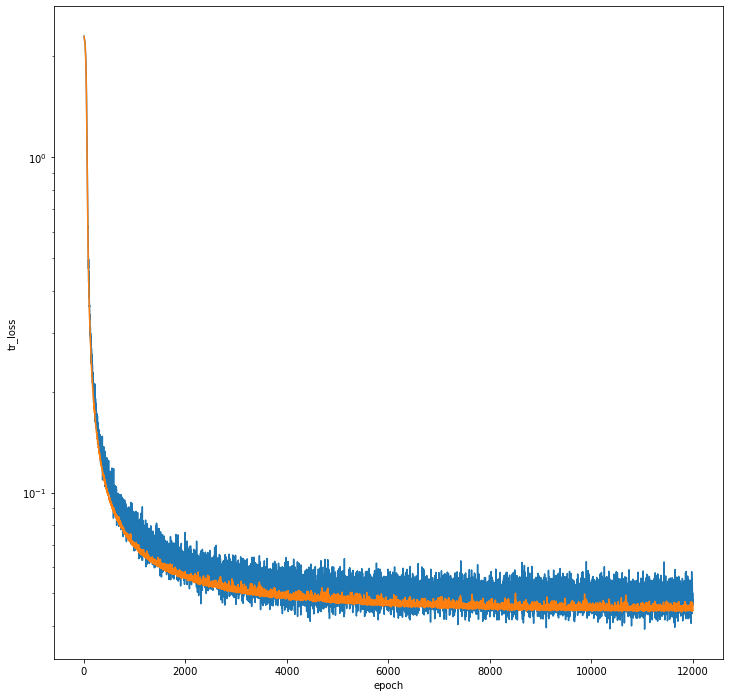

In [81]:
ax = sns.lineplot(x='epoch', y='tr_loss', data=tr_stats_df, legend='full')
sns.lineplot(x='epoch', y='te_loss', data=tr_stats_df, legend='full', ax=ax)
ax.set(yscale="log")

<AxesSubplot:xlabel='epoch', ylabel='tr_score'>

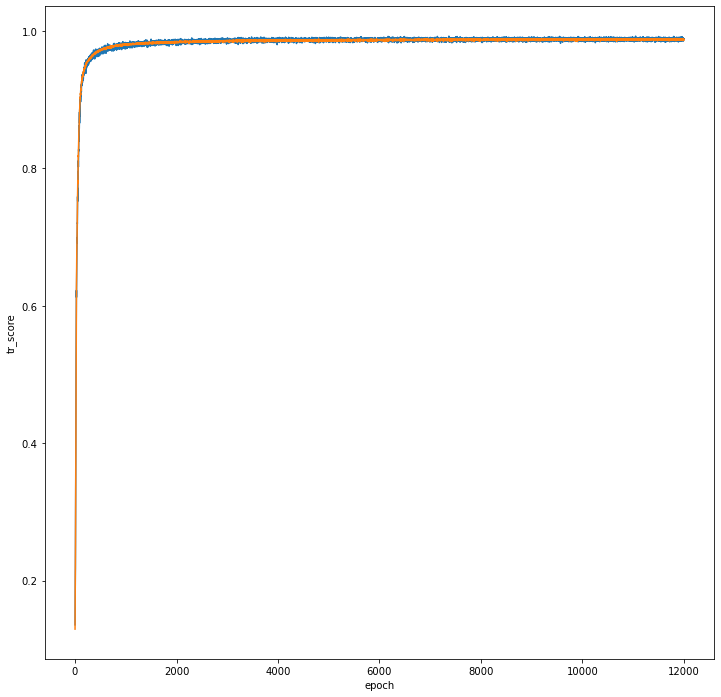

In [82]:
sns.lineplot(x='epoch', y='tr_score', data=tr_stats_df)
sns.lineplot(x='epoch', y='te_score', data=tr_stats_df)

In [83]:
torch.cuda.empty_cache()

In [89]:
#print('Porcentaje acierto en train = %5.2f' % (score_f(add_dim(tX_train), ty_train, nn_cv)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (score_f(add_dim(tX_test), ty_test, nn_cv)*100),'%')

Porcentaje acierto en test = 98.71 %


# 8. Comparativa de métricas y matrices de confusión entre todos los modelos entrenados de ML y DL. (1 punto)

El objetivo de esta sección es comparar los resultados obtenidos entre los distintos modelos (ML, NN, CNN). 

En particular:
- Mostrar la matriz de confusión para cada modelo.
- Elegir y dibujar algunas métricas adicionales. 
- Describir las conclusiones.

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def confu(y_real, y_pred):
    cm_ext1 = confusion_matrix(y_real, y_pred, labels=list(range(10)))
    print(classification_report(y_real, y_pred))
    return pd.DataFrame(cm_ext1, index = list(range(10)), columns = list(range(10)))


In [91]:
print('Clases en la regresion:', 'clf', clf.classes_)
print('Clases en la regresion:', 'neigh', neigh.classes_)
print('Clases en la regresion:', 'cet', cet.classes_)
## Para las "nn" las clases son la posicion del vector porque como hemos definido la funcion predict

Clases en la regresion: clf [0 1 2 3 4 5 6 7 8 9]
Clases en la regresion: neigh [0 1 2 3 4 5 6 7 8 9]
Clases en la regresion: cet [0 1 2 3 4 5 6 7 8 9]


Vemos que todos los algoritmos siguen la misma convencion en la asignacion de las clases a los digitos. Así las matrices de confusión son comparables y estan bien asignadas siendo la primera clase la que precide que la imagen corresponde a un 0 y la ultima clase la que precide que la imagen corresponde a un 9.

#### Regresion logistica

In [98]:
confu(y_test, clf.predict(X_test_hog))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



,0,1,2,3,4,5,6,7,8,9
0,971,1,3,0,0,2,2,0,1,0
1,0,1128,1,0,0,0,2,0,4,0
2,4,2,1009,1,1,0,2,7,6,0
3,0,0,1,990,0,7,0,4,8,0
4,1,2,0,0,960,0,1,1,3,14
5,2,1,0,12,0,872,2,0,3,0
6,4,3,0,0,4,4,941,0,2,0
7,0,3,13,3,5,0,0,997,3,4
8,3,1,4,6,2,1,0,3,947,7
9,2,4,1,6,8,6,1,9,3,969


#### K-Neighbours

In [99]:
confu(y_test, neigh.predict(X_test_hog))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.99      0.95      0.97      1032
           3       0.95      0.96      0.95      1010
           4       0.98      0.93      0.95       982
           5       0.98      0.94      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.90      0.96      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



,0,1,2,3,4,5,6,7,8,9
0,966,2,0,0,0,0,8,1,3,0
1,0,1128,2,0,2,0,2,0,1,0
2,11,4,981,8,0,0,2,13,12,1
3,1,0,2,973,1,6,2,6,14,5
4,4,5,1,0,911,0,6,4,1,50
5,4,1,1,30,1,835,8,0,8,4
6,7,3,0,0,1,6,939,0,2,0
7,1,5,3,1,5,0,0,973,0,40
8,14,4,3,10,1,4,2,4,919,13
9,4,6,1,7,5,2,1,8,3,972


#### Extra Tree

In [100]:
confu(y_test, cet.predict(X_test_hog))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



,0,1,2,3,4,5,6,7,8,9
0,975,2,0,0,0,0,2,0,1,0
1,0,1123,5,2,1,0,2,1,1,0
2,6,2,1013,0,0,0,3,4,4,0
3,1,0,1,991,1,2,0,5,8,1
4,1,0,2,0,961,0,2,0,1,15
5,1,0,1,11,0,870,3,0,4,2
6,6,1,0,0,2,3,944,0,2,0
7,0,2,10,0,2,0,0,1003,1,10
8,9,2,3,2,2,2,1,4,945,4
9,6,6,2,11,6,3,0,7,3,965


#### Neuronal Fully Connected

In [101]:
confu(y_test, pred_f(aplana(tX_test), nn_fc).cpu())

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.95      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.95      0.93      0.94       892
           6       0.94      0.96      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.93      0.94       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



,0,1,2,3,4,5,6,7,8,9
0,962,0,0,1,0,4,10,1,2,0
1,0,1115,3,2,0,1,4,2,8,0
2,8,4,965,9,9,0,11,11,13,2
3,1,1,12,954,1,13,1,15,8,4
4,1,4,4,0,928,0,10,2,3,30
5,9,4,2,15,4,828,14,3,8,5
6,9,3,3,0,8,12,919,1,3,0
7,4,11,23,5,7,0,0,957,3,18
8,5,4,4,14,9,7,12,11,904,4
9,10,8,1,10,21,5,1,8,5,940


#### Neuronal Convolucional

In [102]:
confu(y_test, pred_f(add_dim(tX_test), nn_cv).cpu())

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



,0,1,2,3,4,5,6,7,8,9
0,974,0,1,0,0,0,2,1,2,0
1,0,1130,2,0,0,1,1,0,1,0
2,2,1,1020,3,0,0,0,4,2,0
3,0,0,0,1004,0,3,0,2,1,0
4,0,1,1,0,966,0,1,1,1,11
5,1,0,0,3,0,884,2,1,1,0
6,7,3,0,0,2,4,940,0,2,0
7,1,1,4,4,0,0,0,1014,1,3
8,3,0,3,3,1,1,1,3,955,4
9,3,4,0,5,5,2,0,5,1,984


# 9. Comparativa de la robustez de los distintos modelos entrenados frente a la translación horizontal de los dígitos. (0,5 puntos)

El objetivo de esta sección es:
- Probar el rendimiento de los modelos entrenados sobre distintas transformaciones del set de testing (por ejemplo, sobre translaciones horizontales como se mostró en las sesiones de este módulo).
- Dibujar las gráficas correspondientes de acierto frente a la magnitud de la transformación (por ej. cantidad de píxeles desplazados).
- Describir las conclusiones.

In [105]:
X_test.shape

(10000, 28, 28)

In [106]:
tr_W = np.array(list(range(-14,14)))
X_test_Ws = [np.roll(X_test, i, axis=2) for i in tr_W]

In [107]:
len(X_test_Ws)

28

Estamos viendo un: 4


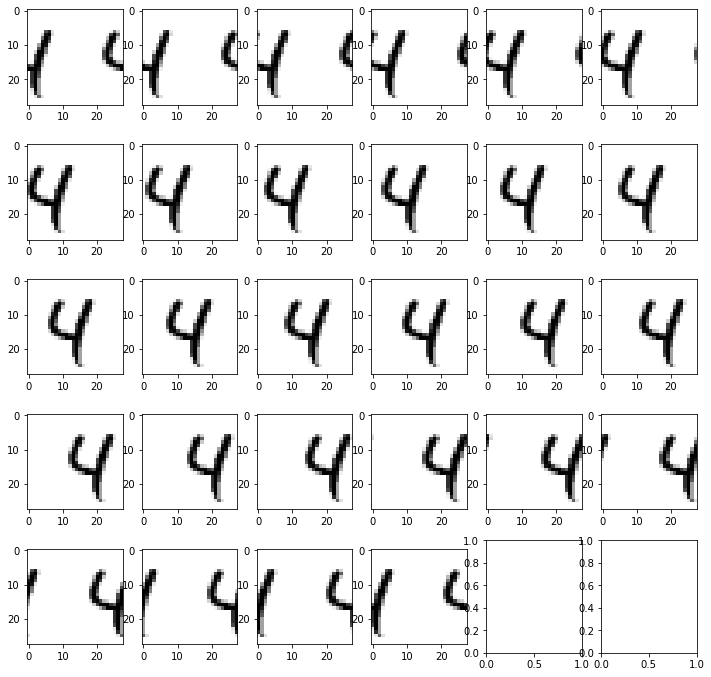

In [108]:
list_imag = np.random.randint(0, high=X_test.shape[0], size=1)[0]
im = io.imshow_collection( [(0.5-X_test_Ws[i][list_imag,:,:]/255) for i in range(len(X_test_Ws))], cmap=plt.cm.gray)
print('Estamos viendo un:', y_test[list_imag])

In [109]:
clf_scores = []
neigh_scores = []
cet_scores = []
nn_fc_scores = []
nn_cv_scores = []

for i in range(len(X_test_Ws)):
    X_test_n = (0.5 - X_test_Ws[i] / 255)

    X_test_hog = hog_opt.transform(X_test_n)
    
    clf_scores.append(clf.score(X_test_hog, y_test))
    neigh_scores.append(neigh.score(X_test_hog, y_test))
    cet_scores.append(cet.score(X_test_hog, y_test))
    
    tX_test = torch.tensor(X_test_n, requires_grad=False, dtype=torch.float, device=dev)
    nn_fc_scores.append(score_f(aplana(tX_test), ty_test, nn_fc))
    nn_cv_scores.append(score_f(add_dim(tX_test), ty_test, nn_cv))
    

In [110]:
all_scores = pd.DataFrame(data={
    'HOG - Log Regre': clf_scores, 
    'HOG - KNeigh':neigh_scores,
    'HOG - ExtTree':cet_scores,
    'Fully Con': nn_fc_scores,
    'Conv': nn_cv_scores
}, index=tr_W)

<AxesSubplot:>

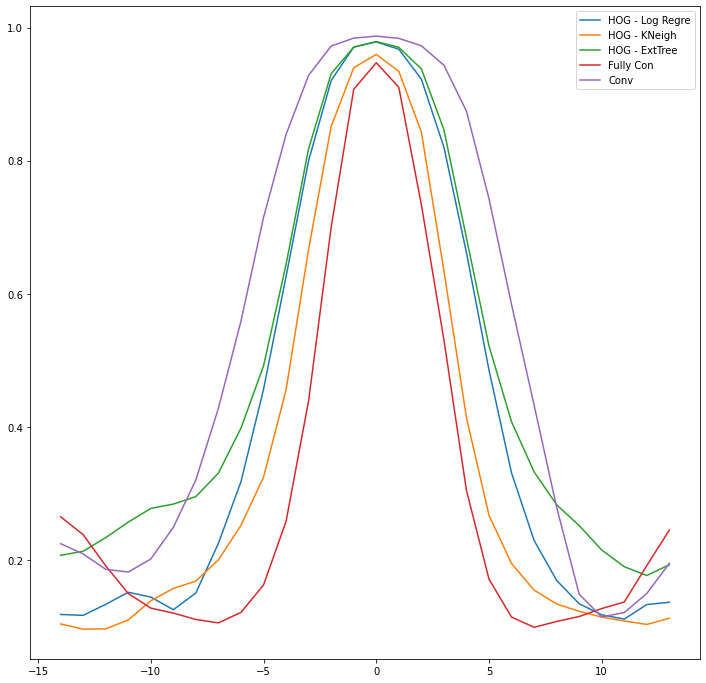

In [111]:
all_scores.plot()

# 10. Desarrollo de una función de preprocesado / reescalado para input al modelo, y exportación del modelo escogido. (0,5 puntos)


El objetiivo de esta sección es el de preparar el modelo para su despliegue en la Parte II de la práctica.

Para ello, habrá que:
- Seleccionar el mejor modelo entre los probados (típicamente, debería ser la CNN).
- Construir una función de preprocesado (o una pipeline de scikit-learn, o equivale) que transforme una imágen genérica en algo consumible por el modelo, replicando también las transformaciones hechas durante el entrenamiento.
- Exportar el modelo y la pipeline en un formato importable desde una aplicación python, como por ejemplo un fichero “.pt” (pytorch) con los pesos de la red neuronal, o una de la pipeline entera a un fichero “.pkl” (pickle).


Nos quedamos con el modelo de red convolucinal pues es el más robusto y que mejor precide sobre el set de test. 

Para contruir una función de preprocesado debemos tener en cuenta que tipo de imagen le estamos dando al modelo. Es una imagen en blanco y negro donde la mayor parte de la imagen es negro y el número esta escrito en blanco. Partimos de un pequeño set creado a mano. El set repite los numero 4 y 7 porque las primeras redes estaban teniendo problemas con esos números, así que le di más muestra. 

In [112]:
import os
from pathlib import Path
DATA_PATH  = Path('set_a_mano/')
set_a_mano_path = list(DATA_PATH.glob('*'))

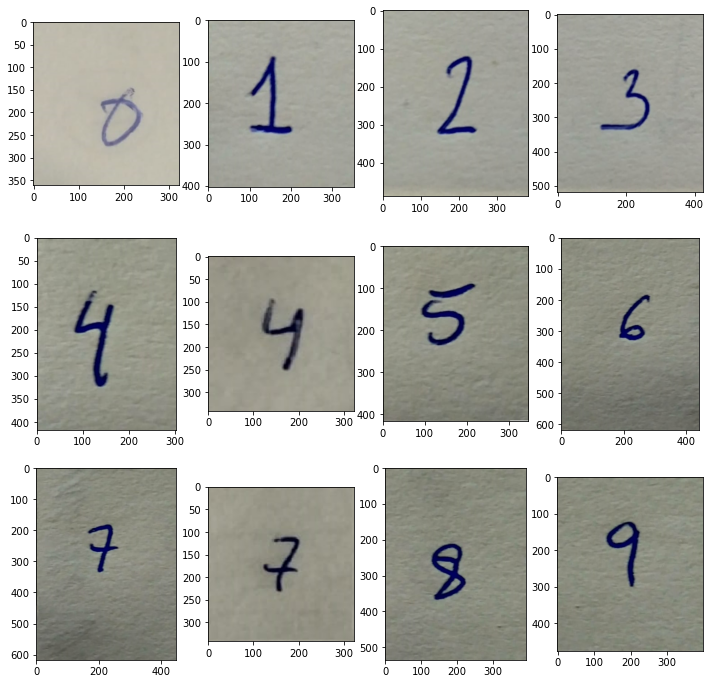

In [113]:
set_a_mano = []
for img in set_a_mano_path:
    # cargamos la imagen para visualizarla como mapa de pixeles
    import_img=io.imread(img.as_posix()) # 0 para cargarla en B&W
    set_a_mano.append(import_img)
    
io.imshow_collection(set_a_mano)
print('')

In [114]:
def rgb2gray(input_img):
    return (input_img[:,:,0]+input_img[:,:,1]+input_img[:,:,2])

def rgba2gray(input_img):
    return (input_img[:,:,0]+input_img[:,:,1]+input_img[:,:,2])*input_img[:,:,3]

In [115]:
def centrado(img):
    limite = 0.95
    f_lados = 1.6

    #img = set_a_mano_pro[0]
    img_test = 255 - img
    img_test.sum()    
    
    for i in range(img.shape[0]):
        if img_test[i:,:].sum() < img_test.sum() * limite :
            y_min = i
            break

    for i in range(img.shape[0]):
        if img_test[:img.shape[0]-i,:].sum() < img_test.sum() * limite :
            y_max = img.shape[0]-i
            break    

    for i in range(img.shape[1]):
        if img_test[:,i:].sum() < img_test.sum() * limite :
            x_min = i
            break

    for i in range(img.shape[1]):
        if img_test[:,:img.shape[1]-i].sum() < img_test.sum() * limite :
            x_max = img.shape[1]-i
            break    

    delta_x = x_max - x_min
    delta_y = y_max - y_min

    delta = max(delta_x,delta_y)
    
    x_cent = x_min + delta_x / 2
    y_cent = y_min + delta_y / 2

    x_min_p = np.uint( np.rint( x_cent - f_lados * delta / 2 ).clip(0,img.shape[1]))
    x_max_p = np.uint( np.rint( x_cent + f_lados * delta / 2 ).clip(0,img.shape[1]))
    y_min_p = np.uint( np.rint( y_cent - f_lados * delta / 2 ).clip(0,img.shape[0]))
    y_max_p = np.uint( np.rint( y_cent + f_lados * delta / 2 ).clip(0,img.shape[0]))  
    
    return 255 - img[y_min_p:y_max_p,x_min_p:x_max_p]

In [116]:
def preprocess(input_img):
    ## Primero pasamos a escala de grises si la imagen no esta en escala de grises, lo hacemos
    ## con numeros float para no llegar a la saturación del canal (pasar del max 255)
    img = np.array(input_img, dtype=float)
    if len(img.shape) == 2:
        ## Imagen en escala de grises
        print('Imagen en escala de grises')
    elif len(img.shape) == 3:
        if img.shape[2] == 4 : ## Imagen en rbga
            img = rgba2gray(img)
        elif  img.shape[2] == 3 : ## Imagen en rbg
            img = rgb2gray(img)
    
    ## Reescalamos grises para añadir el maximo contraste, usamos como max y min
    ## percentiles cuyo limite sería un parametro a tunear, estos funcionan bien con el set que hemos creado 
        
    img = ( (img - np.percentile(img,1)) / (np.percentile(img,90) - np.percentile(img,1)) ) * 255  
    img = np.array(np.clip(img, 0, 255), dtype=np.uint8)
        
    if img.mean() < 125 :  # Si la imagen es negro sobre blanco, med < 125 (mayoría fondo =0)
        img = 255 - img
    
    for j in range(img.shape[1]):  # Saturo el fondo
        for i in range(img.shape[0]):
            if img[i,j] > 125:
                img[i,j] = 255             
        
    # Centramos la imagen
    img = centrado(img) 
          
    # Finalmente la pasamos a 28x28 pixeles 
    img = transform.resize(image=img, output_shape=(28,28), anti_aliasing=True)
    img = np.array(0.5 - img)
    
    # DEBUG
    #io.imshow(img, cmap=plt.cm.gray)
    #print(img)
    #print(img.mean())
    
    return img

In [117]:
set_a_mano_pro = [(preprocess(set_a_mano[i])) for i in range(len(set_a_mano))]

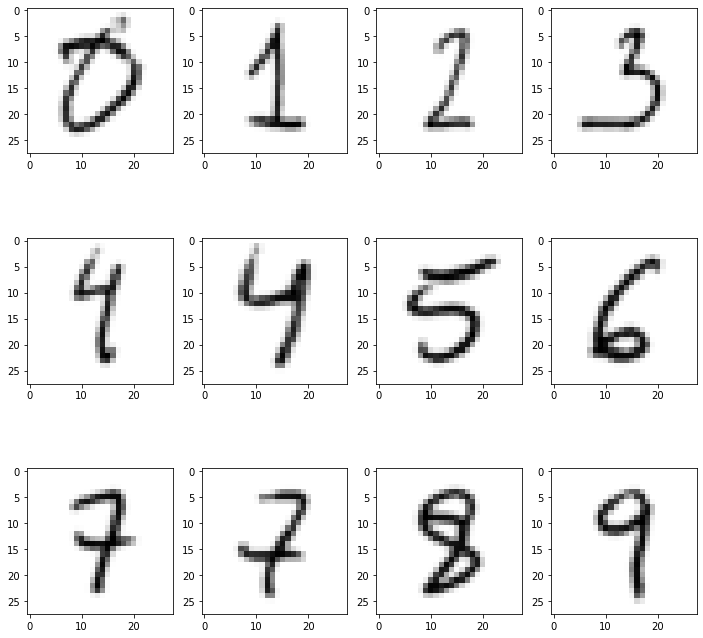

In [119]:
io.imshow_collection(set_a_mano_pro, cmap=plt.cm.gray)
print('')

In [120]:
tSet_a_mano_pro = torch.tensor(set_a_mano_pro, requires_grad=False, dtype=torch.float, device=dev)
pred_f(add_dim(tSet_a_mano_pro), nn_cv)

tensor([0, 1, 2, 3, 1, 4, 5, 6, 7, 7, 8, 9], device='cuda:0')

In [121]:
def Pre_num(img):
    img = preprocess(img)
    timg = torch.tensor(img, requires_grad=False, dtype=torch.float, device=dev)
    a, b = torch.max(nn_cv(timg.unsqueeze(0).unsqueeze(1)), dim=1)
    print('Es un', b.item(), 'con una probabilidad del %6.2f' % (np.exp(a.item())*100), '%' )
    # DEBUG
    io.imshow(img, cmap=plt.cm.gray)


Es un 0 con una probabilidad del  86.01 %


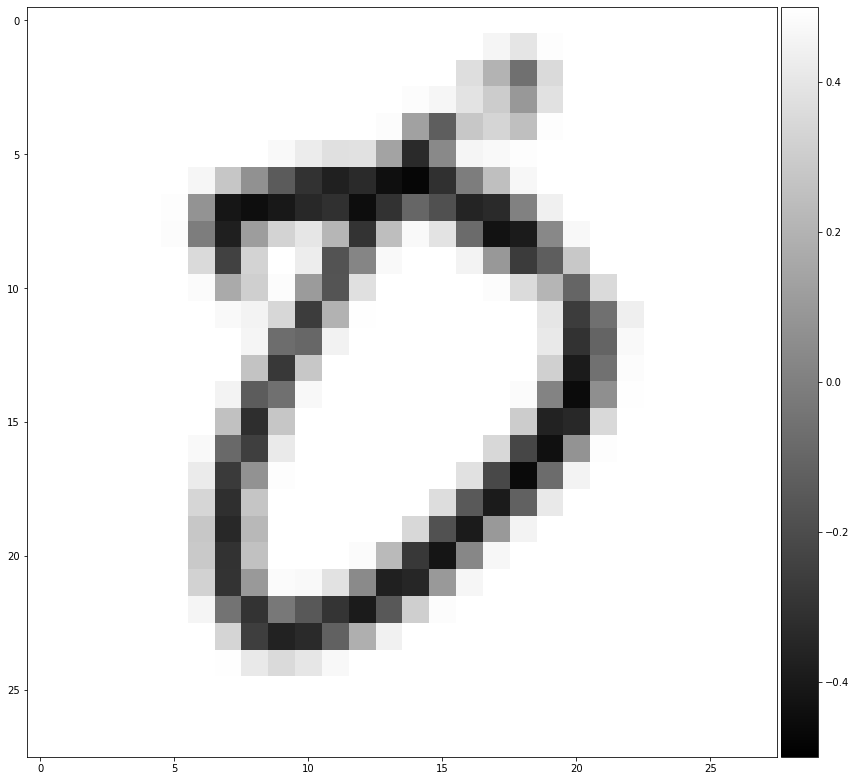

In [122]:
Pre_num(set_a_mano[0])

Imagen en escala de grises
Es un 4 con una probabilidad del  99.97 %


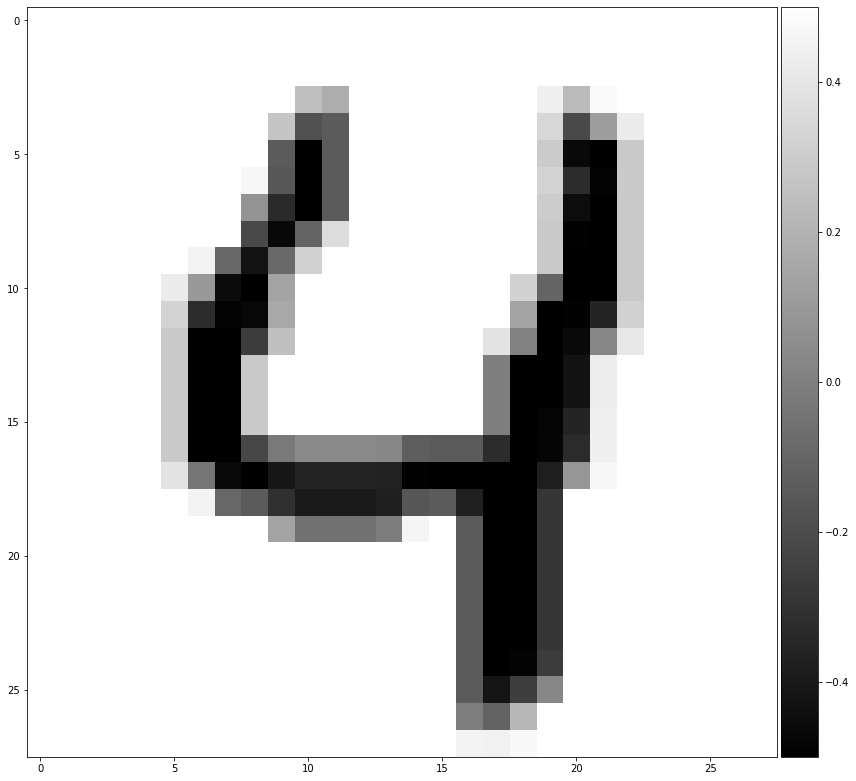

In [125]:
Pre_num(X_test[4])

Exportamos el modelo con el formato de PyTorch

In [124]:
torch.save(nn_cv.state_dict(), 'nn_cv.pt')

In [ ]:
#nn_cv.load_state_dict(torch.load('nn_cv.pt'))

Pensamos que el fallo de la prediccion se debe más al pre-proceso que al modelo pues con más de un 98.5% de acierto en test no parece que este cuatro debíera resultarle dificil de predecir. No nos convence que de una probabilidad erronea tan alta sobre todo teniendo en cuenta que hemos tratado de minimizar la probabilidad en estimaciones erroneas (al usar el "negative log likelihood loss").